<a href="https://colab.research.google.com/github/gwkokab/gwkokab/blob/dev/examples/nvt_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLP for Volume-Time Sensitivity (VT) using GWKokab

GWKokab leverages neural networks to approximate Volume-Time Sensitivity values. This tutorial will walk you through the step-by-step process of training a neural network to predict VT values based on source masses $m_1$ and $m_2$.

To clarify, we will use the following terms throughout this tutorial:
- Classical VT: Refers to the original VT dataset.
- Neural VT: Denotes the neural network trained on the Classical VT dataset.

In [1]:
import h5py
import jax
import numpy as np
from gwkokab.vts.neuralvt import load_model, train_regressor
from jax import numpy as jnp
from matplotlib import pyplot as plt

/usr/local/lib/python3.10/dist-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal
[Loading lalsimutils.py : MonteCarloMarginalization version]
  scipy :  1.11.4
  numpy :  1.25.2


Fetch the VT dataset.

In [2]:
!wget -c https://raw.githubusercontent.com/gwkokab/asset-store/main/classical_vts/vt_1_200_1000.hdf5

--2024-07-13 19:47:45--  https://raw.githubusercontent.com/gwkokab/asset-store/main/classical_vts/vt_1_200_1000.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24002048 (23M) [application/octet-stream]
Saving to: ‘vt_1_200_1000.hdf5’

vt_1_200_1000.hdf5  100%[===================>]  22.89M  --.-KB/s    in 0.1s    

2024-07-13 19:47:45 (169 MB/s) - ‘vt_1_200_1000.hdf5’ saved [24002048/24002048]



In [3]:
!nvidia-smi

Sat Jul 13 19:47:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Preprocessing the VT dataset

It is important to flatten the VT dataset before training the neural network. Some times we get invalid values like negative mass or negative VT values. We need to remove these invalid values from the dataset.

*Note: Normalizing data set is optional. We are not normalizing in this tutorial.*

In [4]:
real_vt_path = r"vt_1_200_1000.hdf5"

with h5py.File(real_vt_path, "r") as f:
    real_VT = f["VT"][:]
    real_m1 = f["m1"][:]
    real_m2 = f["m2"][:]

    real_VT = real_VT.flatten()
    real_m1 = real_m1.flatten()
    real_m2 = real_m2.flatten()


# applying constraints to the data
mask = 0 < real_m1
mask &= 0 < real_m2
mask &= 0 < real_VT


# applying mask to the data
real_m1 = real_m1[mask]
real_m2 = real_m2[mask]
real_VT = real_VT[mask]

For sake of simplicity we are overwriting the VT dataset with the cleaned dataset.

In [5]:
with h5py.File(real_vt_path, "w") as f:
    f.create_dataset("VT", data=real_VT)
    f.create_dataset("m1", data=real_m1)
    f.create_dataset("m2", data=real_m2)

## Training the Neural Network

We are training a neural network to approximate the surface of a function, similar to a regression problem. The Adam optimizer is employed in conjunction with the ReLU activation function to optimize the training process. The mean squared error (MSE) is utilized as the loss function to measure the network's performance. Users have the flexibility to modify the architecture of the neural network by adjusting the number and size of the hidden layers to suit their specific needs. For a detailed explanation of the training process and the available parameters, please refer to the [official documentation](https://gwkokab.readthedocs.io/en/latest/_autosummary/gwkokab.vts.neuralvt.train_regressor.html#gwkokab.vts.neuralvt.train_regressor).

### Observations and Model Adjustments

Through various experimental iterations, we have observed that the MLP struggles to directly learn the VT relationship. However, we have found that the MLP can efficiently learn the logarithmic transformation of VT. Therefore, we have adapted our approach to train the MLP to predict the logarithm of VT, enabling the model to better capture the underlying patterns in the data.

      Summary of the Neural Network Model      
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter        ┃ Value                    ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Input Keys       │ m1, m2                   │
│ Output Keys      │ VT                       │
│ Hidden Layers    │ 128, 128, 128, 128       │
│ Data Path        │ vt_1_200_1000.hdf5       │
│ Checkpoint Path  │ neural_vt_1_200_1000.eqx │
│ Train Size       │ 900000                   │
│ Test Size        │ 100000                   │
│ Validation Split │ 0.1                      │
│ Batch Size       │ 1500                     │
│ Epochs           │ 50                       │
│ Learning Rate    │ 0.001                    │
└──────────────────┴──────────────────────────┘

Output()

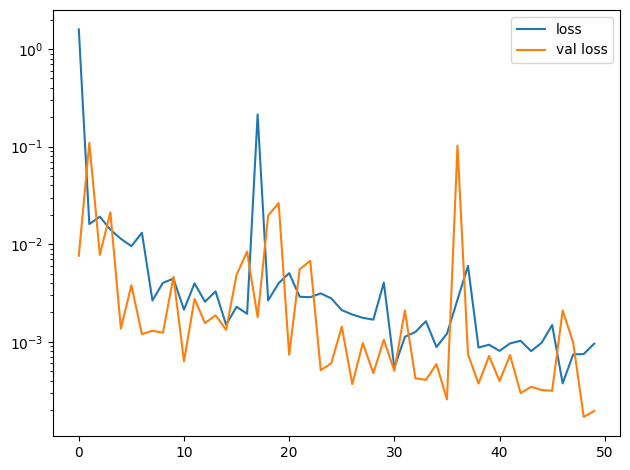

In [6]:
train_regressor(
    input_keys=["m1", "m2"],
    output_keys=["VT"],
    hidden_layers=[128, 128, 128, 128],
    data_path=real_vt_path,
    checkpoint_path="neural_vt_1_200_1000.eqx",
    epochs=50,
    batch_size=1500,
    validation_split=0.1,
)

## Analysis of the Neural VT Model

We can see that the MLP has learned the logarithmic transformation of VT. The model has achieved a high level of accuracy, as evidenced by the low MSE value. The model's performance can be further improved by adjusting the hyperparameters, such as the number of hidden layers and neurons, the learning rate, and the number of epochs. Users are encouraged to experiment with different configurations to optimize the model's performance for their specific use case.

In [7]:
_, logVT_model = load_model("./neural_vt_1_200_1000.eqx")

logVT_model = jax.vmap(logVT_model, in_axes=(0,))

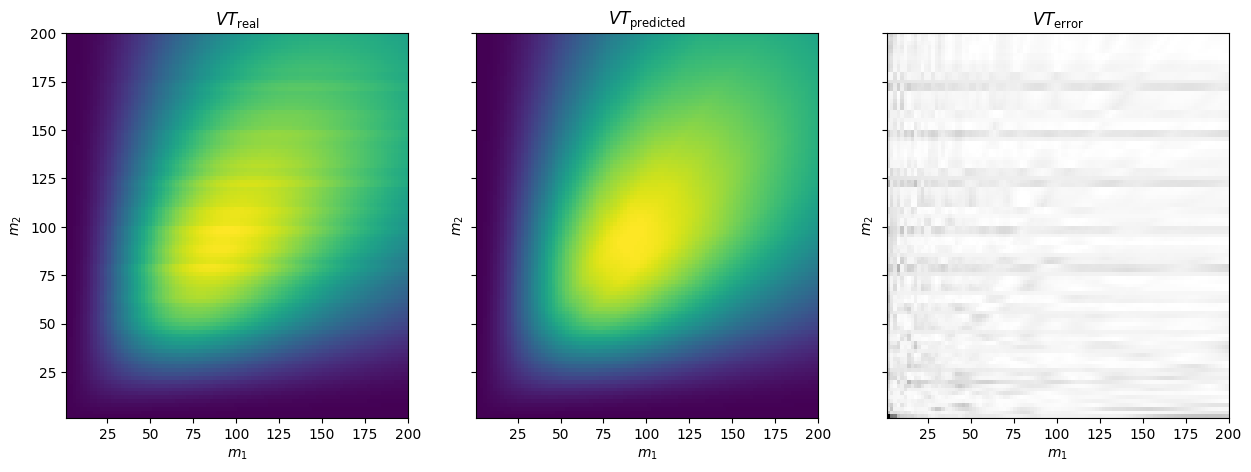

In [8]:
m1m2 = jnp.stack(
    [real_m1, real_m2],
    axis=1,
)
N = 100
vt = jnp.exp(logVT_model(m1m2)).flatten()

fig, ax = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

ax[0].hist2d(real_m1, real_m2, weights=real_VT, bins=N, cmap="viridis")
ax[0].set_title(r"$VT_{\text{real}}$")
ax[0].set_xlabel(r"$m_1$")
ax[0].set_ylabel(r"$m_2$")

ax[1].hist2d(real_m1, real_m2, weights=vt, bins=N, cmap="viridis")
ax[1].set_title(r"$VT_{\text{predicted}}$")
ax[1].set_xlabel(r"$m_1$")
ax[1].set_ylabel(r"$m_2$")

ax[2].hist2d(
    real_m1, real_m2, weights=np.abs(vt - real_VT) / real_VT, bins=N, cmap="Greys"
)
ax[2].set_title(r"$VT_{\text{error}}$")
ax[2].set_xlabel(r"$m_1$")
ax[2].set_ylabel(r"$m_2$")

plt.show()